In [1]:
using POMDPs
using POMDPModels      # for BabyPOMDP
using POMDPModelTools  # for ordered_states
using BeliefUpdaters   # for DiscreteBelief

Create an instance of the BabyPOMDP

In [2]:
pomdp = BabyPOMDP()

BabyPOMDP(-5.0, -10.0, 0.1, 0.8, 0.1, 0.9)

Create a QMDP solver

In [3]:
using QMDP
solver = QMDPSolver()
policy = solve(solver, pomdp)

POMDPPolicies.AlphaVectorPolicy{BabyPOMDP,Bool}(BabyPOMDP(-5.0, -10.0, 0.1, 0.8, 0.1, 0.9), Array{Float64,1}[[-12.3773, -33.5248], [-16.1387, -26.1396]], Bool[false, true])

What is the type of the resulting policy?

In [4]:
typeof(policy)

POMDPPolicies.AlphaVectorPolicy{BabyPOMDP,Bool}

Ok, it's an `AlphaVectorPolicy`. This makes sense, as the result of QMDP is a set of alpha vectors. What fields does it have?

In [5]:
fieldnames(typeof(policy))

(:pomdp, :alphas, :action_map)

Ok, let's see what `alphas` consists of:

In [6]:
policy.alphas

2-element Array{Array{Float64,1},1}:
 [-12.3773, -33.5248]
 [-16.1387, -26.1396]

The `AlphaVectorPolicy` consists of two vectors, one for each action. Each vector has two elements, one for each state.

Let's look at the action map to see which vector maps to which action:

In [7]:
policy.action_map

2-element Array{Bool,1}:
 false
  true

Which index corresponds to which state?

In [8]:
ordered_states(pomdp)

2-element Array{Bool,1}:
 false
  true

The first index corresponds to the hungry=false state, and the second corresponds to the hungry=true state.

We can plot the two vectors:

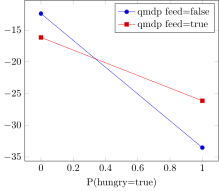

In [9]:
using PGFPlots

p1 = Plots.Linear(ordered_states(pomdp), policy.alphas[1], legendentry="qmdp feed=$(policy.action_map[1])")
p2 = Plots.Linear(ordered_states(pomdp), policy.alphas[2], legendentry="qmdp feed=$(policy.action_map[2])")

Axis([p1,p2], xlabel="P(hungry=true)")

How should we interpret these results? The upper surface represents the value estimate of taking an action given the belief. The upper surface is the maximum over all vectors at a specific belief. A point on the x-axis represents a specific belief, becuase it specifies P(hungry=true) and consequently P(hungry=false).

When we are certain the baby is not hungry (P(hungry=true)=0), not feeding is the correct action, according to this policy.

When we are certain the baby is hungry (P(hungry=true)=1), feeding is the correct action, according to this policy.

According to this policy, the baby should be fed if P(hungry=true) > ~0.35.



In [10]:
action(policy, DiscreteBelief(pomdp, [1.0, 0.0]))

false

In [11]:
action(policy, DiscreteBelief(pomdp, [0.0, 1.0]))

true

In [12]:
value_feed = policy.alphas[1]' * [0.5, 0.5]

-22.951090679521045

In [13]:
value_dont_feed = policy.alphas[2]' * [0.5, 0.5]

-21.139160039668937

Because `value_feed` > `value_dont_feed`, we should feed the baby. We can also see this visually, as the "feed" alpha vector is higher than the "don't feed" alpha vector at P(hungry=true) = 0.5.

Let's briefly explore using FIB, another offline method:

In [14]:
using FIB
fib_solver = FIBSolver()
fib_policy = solve(fib_solver, pomdp)

POMDPPolicies.AlphaVectorPolicy{BabyPOMDP,Bool}(BabyPOMDP(-5.0, -10.0, 0.1, 0.8, 0.1, 0.9), Array{Float64,1}[[-19.4557, -29.4557], [-16.0629, -36.5093]], Bool[false, true])

In [15]:
fib_policy.action_map

2-element Array{Bool,1}:
 false
  true

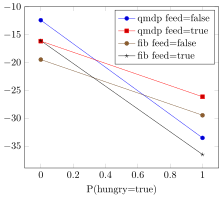

In [16]:
p3 = Plots.Linear(ordered_states(pomdp), fib_policy.alphas[1], legendentry="fib feed=$(fib_policy.action_map[1])")
p4 = Plots.Linear(ordered_states(pomdp), fib_policy.alphas[2], legendentry="fib feed=$(fib_policy.action_map[2])")

Axis([p1,p2,p3,p4], xlabel="P(hungry=true)")

Recall that QMDP is only an approximation and is an upper bound on the value function. FIB is also an approximation, but provides a tighter bound (or at least, that is never looser) than the QMDP bound. Thus, it makes sense that the values from FIB are lower than those of QMDP.